Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

loaded


In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/Turing.jl:81


false

### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Compute the maximum_a_posteriori

In [7]:
result = maximum_a_posteriori(model, lb, ub)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.5278344803167265]
 * Minimizer: [0.6666666666021692]
 * Minimum: 1.297811e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.62e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.35e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.87e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 43
 * Gradient Calls: 43

Use Turing mcmc

In [8]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/support/hmc_core.jl:246
[NUTS{Turing.FluxTrackerAD,Union{}}] found initial ϵ: 0.4
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/support/hmc_core.jl:291
┌ Info:  Adapted ϵ = 1.0169708384755447, std = [1.0]; 200 iterations is used for adaption.
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/adapt/adapt.jl:91


[NUTS] Finished with
  Running time        = 4.928556796000006;
  #lf / sample        = 0.002;
  #evals / sample     = 6.539;
  pre-cond. metric    = [1.0].


Look at the generated draws (in chn)

In [9]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean          SD       Naive SE       MCSE        ESS   
  lf_num  0.0020000000 0.089442719 0.0020000000 0.0020000000 2000.0000
 elapsed  0.0024642784 0.075235635 0.0016823199 0.0021980359 1171.5953
 epsilon  1.0548866415 0.461890119 0.0103281770 0.0271973584  288.4190
   theta  0.6320118370 0.139384359 0.0031167290 0.0049144284  804.4185
      lp -3.3031059558 0.785831841 0.0175717342 0.0220789561 1266.7828
eval_num  6.5390000000 3.424812940 0.0765811454 0.1028281653 1109.3013
  lf_eps  1.0548866415 0.461890119 0.0103281770 0.0271973584  288.4190

Quantiles:
              2.5%         25.0%         50.0%         75.0%         97.5%    
  lf_num  0.0000000000  0.0000000000  0.0000000000  0.000000000  0.00000000000
 elapsed  0.0001347157  0.0001382845  0.0001499945  0.000359588  0.00055348215
 epsilon  0.5855121691  1.0169708385  1.0169708385  1.016970838  1.767188

Look at the mean and sd

In [10]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6339059485766951, 0.13765016043159534)



Fix the inclusion of adaptation samples

In [11]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.0245762 … 22.0 1.01697; 0.0 0.000412524 … 4.0 1.01697; … ; 0.0 0.000145242 … 4.0 1.01697; 0.0 0.000145184 … 4.0 1.01697]

Look at the proper draws (in corrected chn2)

In [12]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                  SD                     Naive SE               MCSE         ESS   
  lf_num  0.00000000000 0.00000000000000000000000 0.000000000000000000000000 0.000000000000       NaN
 elapsed  0.00026535625 0.00064334605836867853230 0.000015163812017404300952 0.000019084184 1136.4284
 epsilon  1.01697083848 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.0000
   theta  0.63390594858 0.13765016043159533642992 0.003244445395753241690590 0.005260408830  684.7223
      lp -3.29160972548 0.75270133426860552638971 0.017741340588983106618670 0.020840661177 1304.4348
eval_num  6.41666666667 2.96388302012344873048733 0.069859392739098497004946 0.059765336315 1800.0000
  lf_eps  1.01697083848 0.00000000000000066631893 0.000000000000000015705288 0.000000000000 1800.0000

Quantiles:
              2.5%           25.0%        50.0%         75.0% 

Compute at hpd region

In [13]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

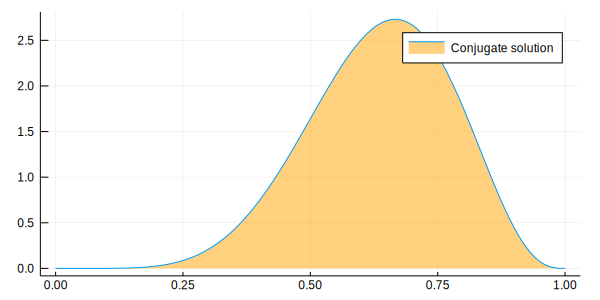

In [14]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

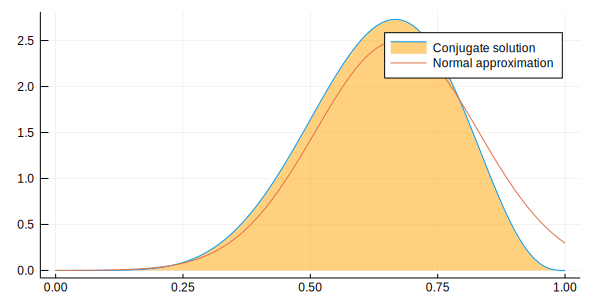

In [15]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

In [16]:
density!(chn2[:theta], lab="Turing chain")
vline!([bnds[1]], line=:dash, lab="hpd lower bound")
vline!([bnds[2]], line=:dash, lab="hpd upper bound")

MethodError: MethodError: no method matching getindex(::Chains{Float64}, ::Symbol)
Closest candidates are:
  getindex(::Chains, ::Any, !Matched::Any, !Matched::Any) at /Users/rob/.julia/packages/MCMCChain/wl69W/src/chains.jl:110
  getindex(::Any, !Matched::AbstractTrees.ImplicitRootState) at /Users/rob/.julia/packages/AbstractTrees/z1wBY/src/AbstractTrees.jl:344

Show hpd region

In [17]:
println("hpd bounds = $bnds\n")

hpd bounds =       94% Lower 94% Upper
theta 0.3873379 0.9004367





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*